In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

2.20.0


# **Define datasets path and load the images into TensorFlow Datasets**

In [3]:
train_dir = r'C:\Users\Asus\IE4483\IE4483datasets\datasets\train'
val_dir   = r'C:\Users\Asus\IE4483\IE4483datasets\datasets\val'
test_dir  = r'C:\Users\Asus\IE4483\IE4483datasets\datasets\test'

# Load images from directory for training/validation
img_size = (64, 64)  # or (224, 224) depending on your model
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

def load_and_preprocess(path):
    img = tf.io.read_file(path)
    # Use decode_image to support png/jpg; expand_animations False avoids 4-D for gifs
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Normalize pixel values for train/val (they come as (x, y) pairs)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds   = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds  = test_ds.map(lambda x, y: (x / 255.0, y))


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [4]:
for images, labels in train_ds.take(1):
    print(images.shape)  # e.g. (32, 32, 32, 3)
    print(labels.shape)  # e.g. (32, 10)

(16, 64, 64, 3)
(16,)


In [5]:
def prepare(ds):
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare(train_ds)
val_ds   = prepare(val_ds)
test_ds  = prepare(test_ds)

# **Convolutional Neural Network (CNN) Model — TensorFlow / Keras**
This script defines a Convolutional Neural Network (CNN) using TensorFlow’s Keras API.
It performs image classification with two output classes.

In [6]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.BatchNormalization(input_shape=(img_size[0], img_size[1], 3)),

    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])


model.summary()

c:\Users\Asus\IE4483\venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,382 (1.09 MB)

 Trainable params: 286,152 (1.09 MB)

 Non-trainable params: 230 (920.00 B)

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# ** Model Compilation and Training — TensorFlow / Keras**
This section defines the optimizer, loss function, metrics, and training procedure for the CNN model.

In [8]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.6256 - loss: 0.8781 - val_accuracy: 0.6780 - val_loss: 0.7161
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.6256 - loss: 0.8781 - val_accuracy: 0.6780 - val_loss: 0.7161
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6956 - loss: 0.7081 - val_accuracy: 0.7146 - val_loss: 0.6594
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6956 - loss: 0.7081 - val_accuracy: 0.7146 - val_loss: 0.6594
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7229 - loss: 0.6610 - val_accuracy: 0.7360 - val_loss: 0.6314
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7229 - loss: 0.6610 - val_accuracy: 0.7360 - val_loss: 0.6314
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7425 - loss: 0.6307 - val_accuracy: 0.7458 - val_loss: 0.6099
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7425 -

# **Results Visualization**

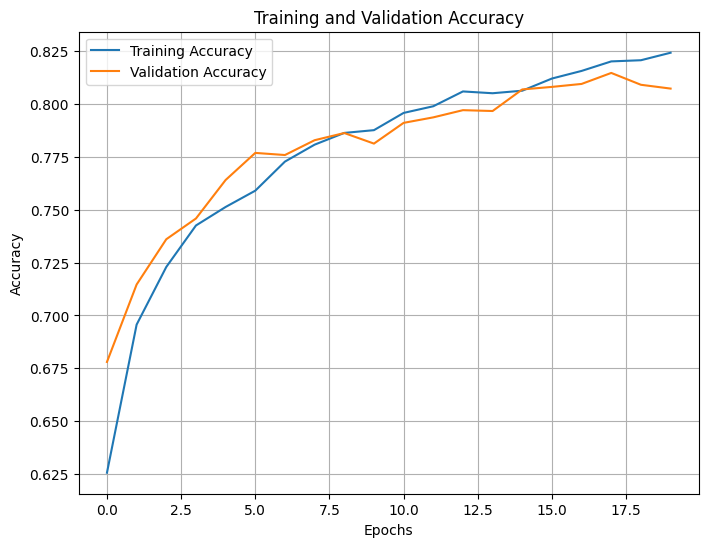

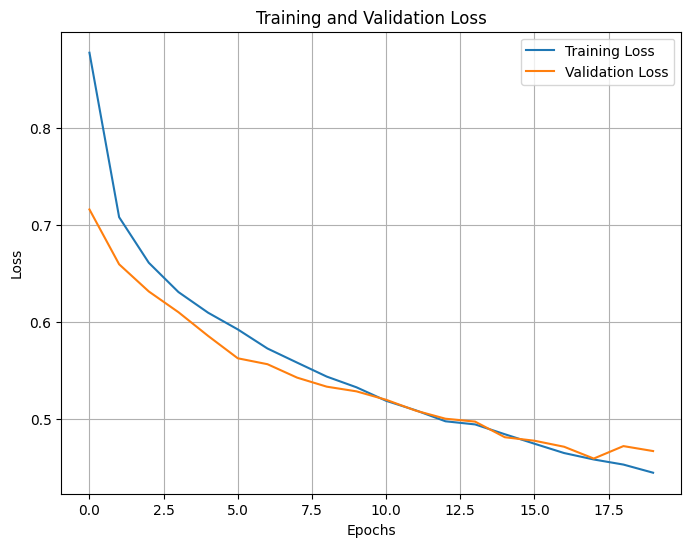

In [9]:
# Accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Evaluating on test dataset...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.

✅ Test Accuracy: 0.8080

=== Classification Report ===

✅ Test Accuracy: 0.8080

=== Classification Report ===
              precision    recall  f1-score   support

         cat       0.80      0.80      0.80       241
         dog       0.82      0.81      0.81       259

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500

              precision    recall  f1-score   support

         cat       0.80      0.80      0.80       241
         dog       0.82      0.81      0.81       259

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



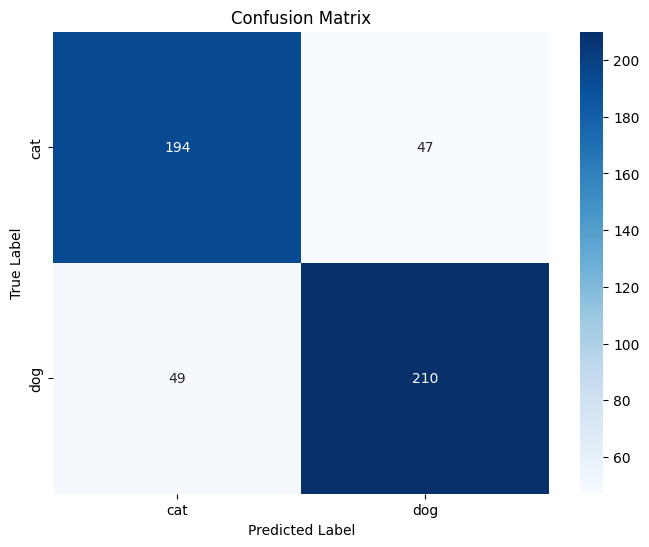

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === Evaluate model ===
print("\nEvaluating on test dataset...")
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# === Class names ===
class_names = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
).class_names

# === Accuracy ===
accuracy = np.mean(y_true == y_pred)
print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

# === Classification Report ===
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

✅ Loaded CSV with 500 entries
Loaded 500 images from C:\Users\Asus\IE4483\IE4483datasets\datasets\test_unclassified
 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/stepLoaded 500 images from C:\Users\Asus\IE4483\IE4483datasets\datasets\test_unclassified
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

✅ Test Accuracy: 0.8040

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       242
           1       0.81      0.81      0.81       258

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500


✅ Test Accuracy: 0.8040

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       242
           1       0.81      0.81      0.81       258

    accuracy                           0.80       500
   macro avg       0.

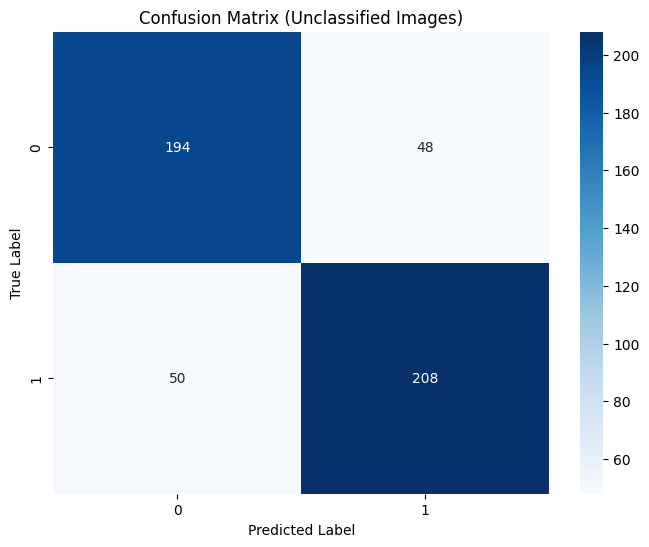


📁 Predictions saved to: C:\Users\Asus\IE4483\IE4483datasets\datasets\CNNpredicted_labels.csv


In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# === Paths ===
csv_path = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\testClassification.csv"
img_dir = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\test_unclassified"
output_csv = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\CNNpredicted_labels.csv"

# === Load CSV (no header) ===
df = pd.read_csv(csv_path, header=None, names=["filename", "label"])
print("✅ Loaded CSV with", len(df), "entries")

# === Load and preprocess images ===
img_size = (64, 64)  # same as during training
images = []
true_labels = []
filenames = []  

for _, row in df.iterrows():
    fname = str(row["filename"])      # use fname to avoid name conflict
    label = int(row["label"])
    img_path = os.path.join(img_dir, f"{fname}.jpg")  # adjust extension if needed
    if not os.path.exists(img_path):
        print(f"⚠️ Missing file: {img_path}")
        continue

    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    images.append(img_array)
    true_labels.append(label)
    filenames.append(fname)  # <-- collect filename here

images = np.array(images)
true_labels = np.array(true_labels)

print(f"Loaded {len(images)} images from {img_dir}")

# === Predict ===
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# === Accuracy ===
accuracy = np.mean(predicted_classes == true_labels)
print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

# === Classification Report ===
print("=== Classification Report ===")
print(classification_report(true_labels, predicted_classes))

# === Confusion Matrix ===
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Unclassified Images)')
plt.show()

# === Save predictions to CSV ===
results_df = pd.DataFrame({
    "filename": filenames,
    "true_label": true_labels,
    "predicted_label": predicted_classes
})
results_df.to_csv(output_csv, index=False)
print(f"\n📁 Predictions saved to: {output_csv}")


## 🚨 **Misclassified Images Analysis**

Let's analyze which images the model got wrong and see how data augmentation affects predictions by comparing original images with their augmented versions.

In [12]:
# ==========================================
# FIND AND ANALYZE MISCLASSIFIED IMAGES
# ==========================================

print("🔍 Finding misclassified images from test set...")

# Get test data without augmentation for analysis
test_ds_original = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # Keep original order for analysis
)

# Normalize but don't augment
test_ds_clean = test_ds_original.map(lambda x, y: (x / 255.0, y))

# Get original images, labels, and predictions
original_images = []
original_labels = []
for images, labels in test_ds_clean:
    original_images.append(images.numpy())
    original_labels.append(labels.numpy())

original_images = np.concatenate(original_images, axis=0)
original_labels = np.concatenate(original_labels, axis=0)

# Get predictions on original (non-augmented) images
print("Getting predictions on original images...")
original_predictions = model.predict(test_ds_clean, verbose=1)
original_pred_classes = np.argmax(original_predictions, axis=1)
original_confidence = np.max(original_predictions, axis=1)

# Find misclassified images
misclassified_mask = original_pred_classes != original_labels
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Found {len(misclassified_indices)} misclassified images out of {len(original_labels)}")
print(f"Accuracy on original images: {np.mean(original_pred_classes == original_labels):.4f}")

# Get class names
class_names = test_ds_original.class_names
print(f"Classes: {class_names}")

# Show some statistics
print(f"\n📊 Misclassification Statistics:")
for i, class_name in enumerate(class_names):
    class_mask = original_labels == i
    misclass_in_class = np.sum(misclassified_mask & class_mask)
    total_in_class = np.sum(class_mask)
    if total_in_class > 0:
        error_rate = misclass_in_class / total_in_class
        print(f"  {class_name}: {misclass_in_class}/{total_in_class} ({error_rate:.2%} error rate)")

🔍 Finding misclassified images from test set...
Found 500 files belonging to 2 classes.
Getting predictions on original images...
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepGetting predictions on original images...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Found 96 misclassified images out of 500
Accuracy on original images: 0.8080
Classes: ['cat', 'dog']

📊 Misclassification Statistics:
  cat: 47/241 (19.50% error rate)
  dog: 49/259 (18.92% error rate)
Found 96 misclassified images out of 500
Accuracy on original images: 0.8080
Classes: ['cat', 'dog']

📊 Misclassification Statistics:
  cat: 47/241 (19.50% error rate)
  dog: 49/259 (18.92% error rate)


🖼️ Showing misclassified images with different augmentations...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0252421].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0171454].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0171454].
C:\Users\Asus\AppData\Local\Temp\ipykernel_24168\1541027908.py:80: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_24168\1541027908.py:80: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c

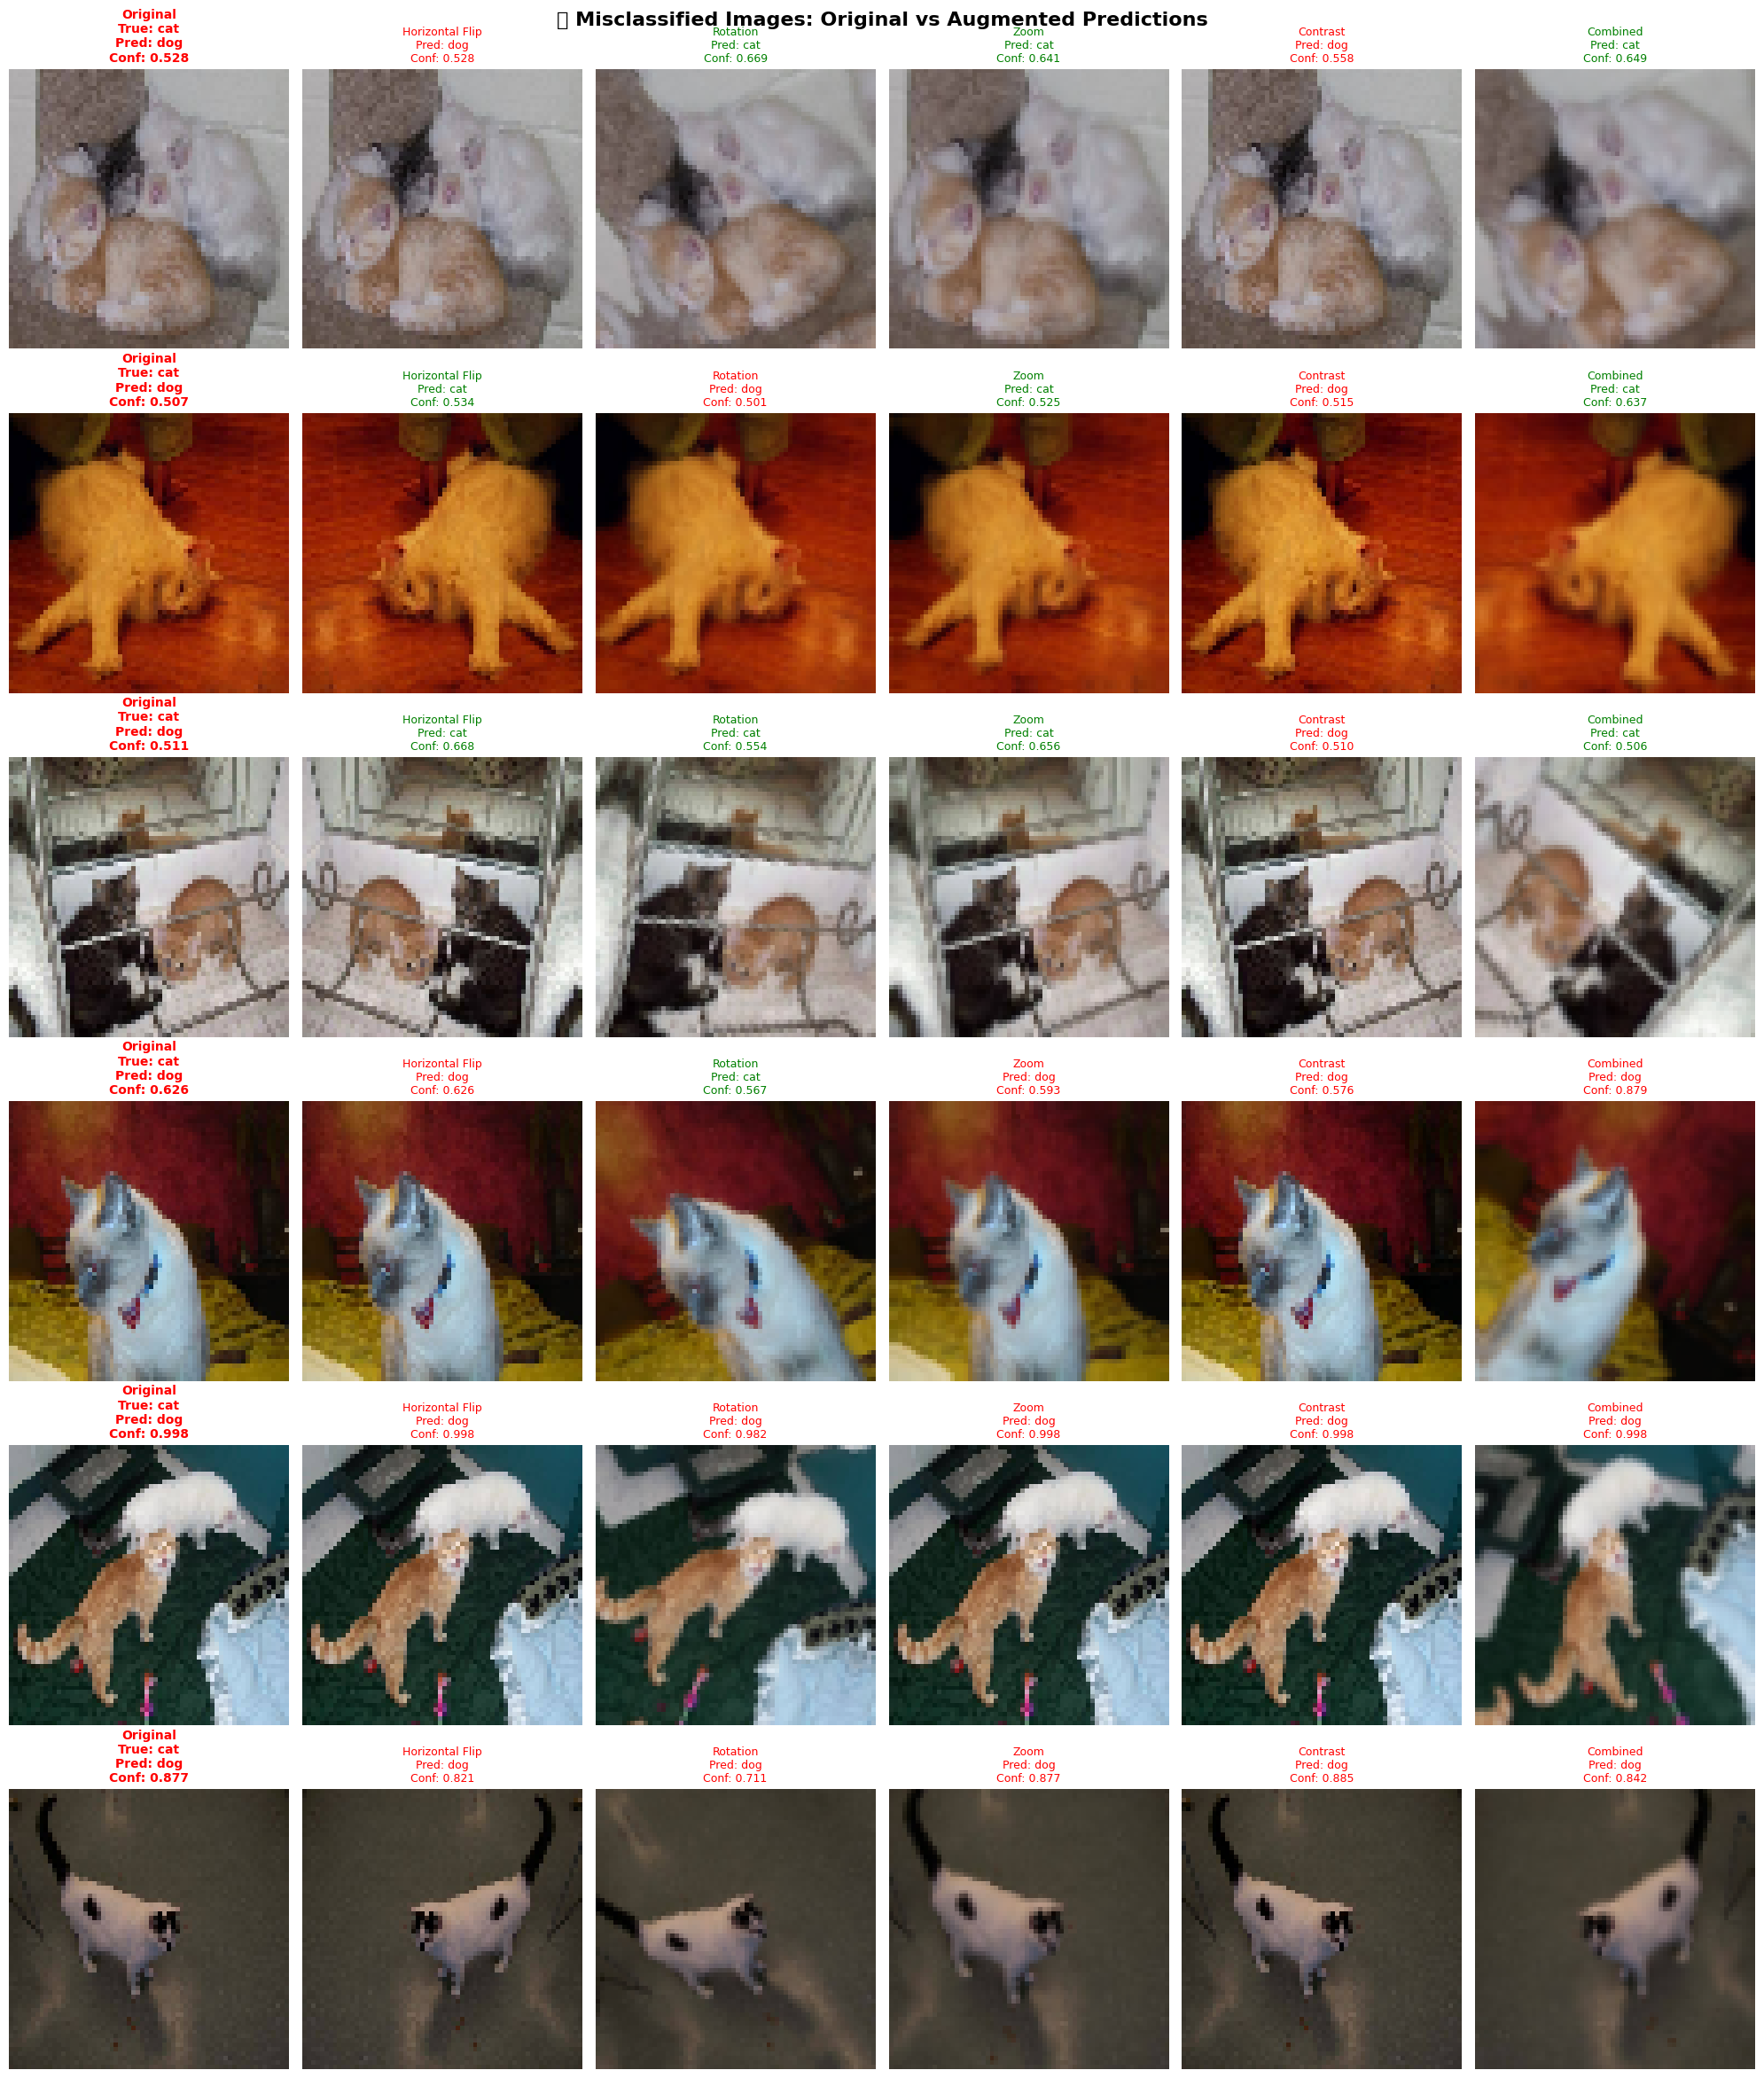

In [13]:
# ==========================================
# VISUALIZE ORIGINAL vs AUGMENTED PREDICTIONS
# ==========================================

def apply_single_augmentation(image, aug_layer):
    """Apply a single augmentation to an image"""
    # Add batch dimension
    image_batch = tf.expand_dims(image, 0)
    # Apply augmentation
    augmented = aug_layer(image_batch, training=True)
    # Remove batch dimension
    return tf.squeeze(augmented, 0)

def show_original_vs_augmented_predictions(indices, max_samples=8):
    """Show original images vs augmented versions with predictions"""
    
    n_samples = min(len(indices), max_samples)
    selected_indices = indices[:n_samples]
    
    # Create figure
    fig, axes = plt.subplots(n_samples, 6, figsize=(20, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('🔍 Misclassified Images: Original vs Augmented Predictions', fontsize=16, fontweight='bold')
    
    for i, idx in enumerate(selected_indices):
        original_img = original_images[idx]
        true_label = class_names[original_labels[idx]]
        
        # Original image prediction
        orig_pred_class = class_names[original_pred_classes[idx]]
        orig_confidence = original_confidence[idx]
        
        # Generate different augmented versions
        augmented_images = []
        augmented_preds = []
        augmented_confs = []
        
        # Create individual augmentation layers for demonstration
        aug_layers = [
            tf.keras.Sequential([layers.RandomFlip("horizontal")]),
            tf.keras.Sequential([layers.RandomRotation(0.1)]),
            tf.keras.Sequential([layers.RandomZoom(0.1)]),
            tf.keras.Sequential([layers.RandomContrast(0.1)]),
            data_augmentation  # Combined augmentation
        ]
        
        aug_names = ['Horizontal Flip', 'Rotation', 'Zoom', 'Contrast', 'Combined']
        
        for aug_layer in aug_layers:
            # Apply augmentation
            aug_img = apply_single_augmentation(original_img, aug_layer)
            augmented_images.append(aug_img.numpy())
            
            # Get prediction for augmented image
            aug_pred = model.predict(tf.expand_dims(aug_img, 0), verbose=0)
            aug_pred_class = np.argmax(aug_pred)
            aug_confidence = np.max(aug_pred)
            
            augmented_preds.append(class_names[aug_pred_class])
            augmented_confs.append(aug_confidence)
        
        # Plot original image
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f'Original\nTrue: {true_label}\nPred: {orig_pred_class}\nConf: {orig_confidence:.3f}', 
                            color='red', fontsize=10, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Plot augmented versions
        for j, (aug_img, aug_pred, aug_conf, aug_name) in enumerate(zip(augmented_images, augmented_preds, augmented_confs, aug_names)):
            axes[i, j+1].imshow(aug_img)
            
            # Color code: green if correct, red if wrong
            color = 'green' if aug_pred == true_label else 'red'
            axes[i, j+1].set_title(f'{aug_name}\nPred: {aug_pred}\nConf: {aug_conf:.3f}', 
                                  color=color, fontsize=9)
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show misclassified images with augmentation analysis
if len(misclassified_indices) > 0:
    print("🖼️ Showing misclassified images with different augmentations...")
    show_original_vs_augmented_predictions(misclassified_indices, max_samples=6)
else:
    print("🎉 No misclassified images found! Perfect accuracy!")

C:\Users\Asus\AppData\Local\Temp\ipykernel_24168\2280586644.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_confidence, misclass_confidence],


📊 CONFIDENCE ANALYSIS FOR MISCLASSIFIED IMAGES
Misclassified images confidence: Mean = 0.684, Std = 0.139
Correctly classified confidence: Mean = 0.844, Std = 0.144


c:\Users\Asus\IE4483\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


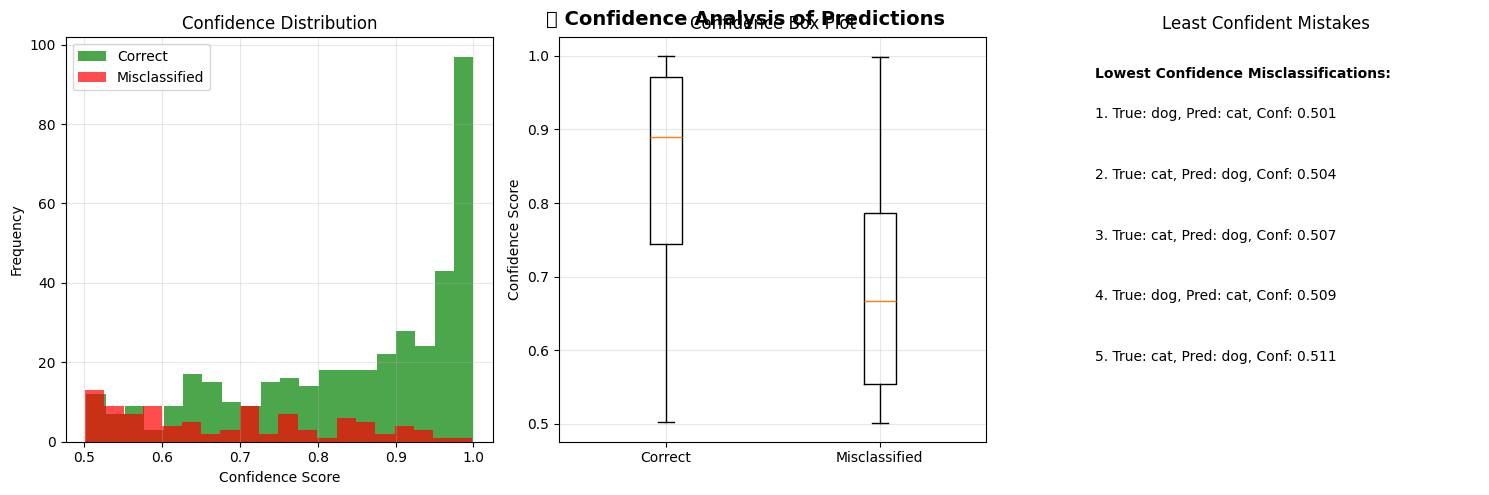


🔍 DETAILED ANALYSIS OF MISCLASSIFIED IMAGES:
------------------------------------------------------------
 1. Image Index:   0 | True: cat      | Predicted: dog      | Confidence: 0.5285
 2. Image Index:  16 | True: cat      | Predicted: dog      | Confidence: 0.5066
 3. Image Index:  17 | True: cat      | Predicted: dog      | Confidence: 0.5112
 4. Image Index:  21 | True: cat      | Predicted: dog      | Confidence: 0.6263
 5. Image Index:  22 | True: cat      | Predicted: dog      | Confidence: 0.9979
 6. Image Index:  28 | True: cat      | Predicted: dog      | Confidence: 0.8767
 7. Image Index:  37 | True: cat      | Predicted: dog      | Confidence: 0.9168
 8. Image Index:  43 | True: cat      | Predicted: dog      | Confidence: 0.8113
 9. Image Index:  46 | True: cat      | Predicted: dog      | Confidence: 0.5036
10. Image Index:  47 | True: cat      | Predicted: dog      | Confidence: 0.8400
    ... and 86 more misclassified images



In [14]:
# ==========================================
# CONFIDENCE ANALYSIS FOR MISCLASSIFIED IMAGES
# ==========================================

print("📊 CONFIDENCE ANALYSIS FOR MISCLASSIFIED IMAGES")
print("="*60)

if len(misclassified_indices) > 0:
    # Analyze confidence distribution
    correct_indices = np.where(~misclassified_mask)[0]
    
    misclass_confidence = original_confidence[misclassified_indices]
    correct_confidence = original_confidence[correct_indices]
    
    print(f"Misclassified images confidence: Mean = {np.mean(misclass_confidence):.3f}, Std = {np.std(misclass_confidence):.3f}")
    print(f"Correctly classified confidence: Mean = {np.mean(correct_confidence):.3f}, Std = {np.std(correct_confidence):.3f}")
    
    # Plot confidence distributions
    plt.figure(figsize=(15, 5))
    
    # Confidence histogram
    plt.subplot(1, 3, 1)
    plt.hist(correct_confidence, bins=20, alpha=0.7, label='Correct', color='green')
    plt.hist(misclass_confidence, bins=20, alpha=0.7, label='Misclassified', color='red')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Box plot
    plt.subplot(1, 3, 2)
    plt.boxplot([correct_confidence, misclass_confidence], 
                labels=['Correct', 'Misclassified'])
    plt.ylabel('Confidence Score')
    plt.title('Confidence Box Plot')
    plt.grid(True, alpha=0.3)
    
    # Show lowest confidence misclassified images
    plt.subplot(1, 3, 3)
    lowest_conf_indices = misclassified_indices[np.argsort(misclass_confidence)[:5]]
    
    for i, idx in enumerate(lowest_conf_indices):
        plt.subplot(1, 3, 3)
        if i == 0:  # Only create the subplot once
            plt.text(0.1, 0.9-i*0.15, f"Lowest Confidence Misclassifications:", 
                    transform=plt.gca().transAxes, fontweight='bold')
        
        true_label = class_names[original_labels[idx]]
        pred_label = class_names[original_pred_classes[idx]]
        conf = original_confidence[idx]
        
        plt.text(0.1, 0.8-i*0.15, f"{i+1}. True: {true_label}, Pred: {pred_label}, Conf: {conf:.3f}", 
                transform=plt.gca().transAxes, fontsize=10)
    
    plt.axis('off')
    plt.title('Least Confident Mistakes')
    
    plt.tight_layout()
    plt.suptitle('📈 Confidence Analysis of Predictions', fontsize=14, fontweight='bold')
    plt.show()
    
    # Detailed analysis of each misclassified image
    print(f"\n🔍 DETAILED ANALYSIS OF MISCLASSIFIED IMAGES:")
    print("-" * 60)
    
    for i, idx in enumerate(misclassified_indices[:10]):  # Show first 10
        true_label = class_names[original_labels[idx]]
        pred_label = class_names[original_pred_classes[idx]]
        conf = original_confidence[idx]
        
        print(f"{i+1:2d}. Image Index: {idx:3d} | True: {true_label:8s} | Predicted: {pred_label:8s} | Confidence: {conf:.4f}")
    
    if len(misclassified_indices) > 10:
        print(f"    ... and {len(misclassified_indices) - 10} more misclassified images")

else:
    print("🎉 Perfect accuracy! No misclassified images to analyze.")

print("\n" + "="*60)

In [15]:
# ==========================================
# DATA AUGMENTATION IMPACT ANALYSIS
# ==========================================

print("🎯 ANALYZING HOW DATA AUGMENTATION AFFECTS PREDICTIONS")
print("="*65)

def test_augmentation_impact(sample_indices, num_trials=10):
    """Test how augmentation affects predictions for specific images"""
    
    results = []
    
    for idx in sample_indices[:5]:  # Test first 5 samples
        original_img = original_images[idx]
        true_label = class_names[original_labels[idx]]
        
        # Original prediction
        orig_pred = model.predict(tf.expand_dims(original_img, 0), verbose=0)
        orig_class = class_names[np.argmax(orig_pred)]
        orig_conf = np.max(orig_pred)
        
        # Test multiple augmented versions
        aug_predictions = []
        aug_confidences = []
        aug_classes = []
        
        for trial in range(num_trials):
            # Apply combined augmentation
            aug_img = apply_single_augmentation(original_img, data_augmentation)
            aug_pred = model.predict(tf.expand_dims(aug_img, 0), verbose=0)
            
            aug_class = np.argmax(aug_pred)
            aug_conf = np.max(aug_pred)
            
            aug_predictions.append(aug_class)
            aug_confidences.append(aug_conf)
            aug_classes.append(class_names[aug_class])
        
        # Calculate statistics
        aug_accuracy = np.mean([class_names[pred] == true_label for pred in aug_predictions])
        avg_aug_conf = np.mean(aug_confidences)
        std_aug_conf = np.std(aug_confidences)
        
        # Count predictions for each class
        class_counts = {}
        for cls in aug_classes:
            class_counts[cls] = class_counts.get(cls, 0) + 1
        
        results.append({
            'idx': idx,
            'true_label': true_label,
            'orig_pred': orig_class,
            'orig_conf': orig_conf,
            'aug_accuracy': aug_accuracy,
            'avg_aug_conf': avg_aug_conf,
            'std_aug_conf': std_aug_conf,
            'class_counts': class_counts
        })
        
        print(f"\n📷 Image {idx} (True: {true_label}):")
        print(f"  Original: Pred={orig_class}, Conf={orig_conf:.3f}")
        print(f"  Augmented ({num_trials} trials): Accuracy={aug_accuracy:.1%}, Avg Conf={avg_aug_conf:.3f}±{std_aug_conf:.3f}")
        print(f"  Prediction distribution: {class_counts}")
    
    return results

# Test augmentation impact on misclassified images
if len(misclassified_indices) > 0:
    print("Testing augmentation impact on MISCLASSIFIED images:")
    misclass_results = test_augmentation_impact(misclassified_indices, num_trials=10)
    
    # Also test on some correctly classified images for comparison
    correct_indices = np.where(~misclassified_mask)[0]
    if len(correct_indices) > 0:
        print(f"\n" + "="*65)
        print("Testing augmentation impact on CORRECTLY CLASSIFIED images (for comparison):")
        correct_results = test_augmentation_impact(correct_indices, num_trials=10)
        
        # Compare stability
        print(f"\n📊 STABILITY COMPARISON:")
        print("-" * 40)
        
        if misclass_results:
            misclass_stability = np.mean([r['std_aug_conf'] for r in misclass_results])
            correct_stability = np.mean([r['std_aug_conf'] for r in correct_results]) if correct_results else 0
            
            print(f"Misclassified images - Avg confidence std: {misclass_stability:.3f}")
            print(f"Correct images - Avg confidence std: {correct_stability:.3f}")
            
            if misclass_stability > correct_stability:
                print("➡️ Misclassified images show MORE variation with augmentation (less stable)")
            else:
                print("➡️ Misclassified images show LESS variation with augmentation (more stable)")

else:
    # If no misclassified images, test on random samples
    print("No misclassified images found. Testing on random samples:")
    random_indices = np.random.choice(len(original_images), size=min(5, len(original_images)), replace=False)
    test_augmentation_impact(random_indices, num_trials=10)

print("\n" + "="*65)
print("✅ Analysis complete! Check the visualizations above to see how data augmentation")
print("   affects individual predictions and whether it helps correct misclassifications.")

🎯 ANALYZING HOW DATA AUGMENTATION AFFECTS PREDICTIONS
Testing augmentation impact on MISCLASSIFIED images:

📷 Image 0 (True: cat):
  Original: Pred=dog, Conf=0.528
  Augmented (10 trials): Accuracy=100.0%, Avg Conf=0.776±0.077
  Prediction distribution: {'cat': 10}

📷 Image 0 (True: cat):
  Original: Pred=dog, Conf=0.528
  Augmented (10 trials): Accuracy=100.0%, Avg Conf=0.776±0.077
  Prediction distribution: {'cat': 10}

📷 Image 16 (True: cat):
  Original: Pred=dog, Conf=0.507
  Augmented (10 trials): Accuracy=100.0%, Avg Conf=0.557±0.029
  Prediction distribution: {'cat': 10}

📷 Image 16 (True: cat):
  Original: Pred=dog, Conf=0.507
  Augmented (10 trials): Accuracy=100.0%, Avg Conf=0.557±0.029
  Prediction distribution: {'cat': 10}

📷 Image 17 (True: cat):
  Original: Pred=dog, Conf=0.511
  Augmented (10 trials): Accuracy=60.0%, Avg Conf=0.625±0.075
  Prediction distribution: {'cat': 6, 'dog': 4}

📷 Image 17 (True: cat):
  Original: Pred=dog, Conf=0.511
  Augmented (10 trials): Accu